# Configuration 

In [1]:
cd '/Users/xusikun/Desktop/Research/[research]tsinghua_options/options-study'

/Users/xusikun/Desktop/Research/[research]tsinghua_options/options-study


In [2]:
import os 

import pandas as pd 
import numpy as np

from datetime import datetime

import backtrader as bt

In [3]:
DATA = 'data/'

# Prepare data

In this step, we need to prepare both the price data and the portofolio data. The portfolio data describes the portofolio at each re-balancing time. 

*Note that the strategy development should be run a priori. The backtest system only make use of the strategy results. It doesn't accept a strategy function or class as inputs*. 

## Sample Data

In [4]:
from src.data import prepare_sample_data

In [5]:
prepare_sample_data_params = {
    'price_direc': os.path.join(DATA, 'sample/daily_price.csv'), 
    'portfolio_direc': os.path.join(DATA, 'sample/trade_info.csv')
}

In [6]:
data = prepare_sample_data(**prepare_sample_data_params)
price, portfolio = data['price'], data['portfolio']

In [7]:
portfolio

,trade_date,sec_code,weight
0,2019-01-31,000006.SZ,0.007282
1,2019-01-31,000008.SZ,0.009783
2,2019-01-31,000025.SZ,0.006928
3,2019-01-31,000090.SZ,0.007234
4,2019-01-31,000536.SZ,0.003536
...,...,...,...
2490,2021-01-28,603712.SH,0.007630
2491,2021-01-28,603737.SH,0.019291
2492,2021-01-28,603816.SH,0.022646
2493,2021-01-28,603866.SH,0.018611


## Options Data

In [8]:
from src.options_data import prepare_options_price_data_from_op510050, resample_options_data, read_options_data

In [9]:
%%time
# read and preprocess options data
price = prepare_options_price_data_from_op510050(
    filepath="/Volumes/Sikun's T7/data/[project]tsinghua_options_research/options.csv", 
#     raw1=folder1, raw2=folder2, 
#     save=True, save_filepath="/Volumes/Sikun's T7/data/[project]tsinghua_options_research/options.csv", 
)

CPU times: user 40.9 s, sys: 13.3 s, total: 54.2 s
Wall time: 1min 3s


In [10]:
%%time
daily_price = resample_options_data(price, freq='1D')

CPU times: user 38.8 s, sys: 5.87 s, total: 44.6 s
Wall time: 47.5 s


In [11]:
daily_price.head()

,sec_code,open,high,low,close,volume,open_oi,close_oi
datetime,,,,,,,,
2018-01-02,10000969,0.0,0.3938,0.0,0.3931,956,0,0
2018-01-03,10000969,0.0,0.4239,0.0,0.3988,342,0,0
2018-01-04,10000969,0.0,0.4164,0.0,0.4014,854,0,0
2018-01-05,10000969,0.0,0.4168,0.0,0.4129,327,0,0
2018-01-06,10000969,0.0,0.4168,0.0,0.4129,0,0,0


### Strangle

In [12]:
from src.strategy import get_daily_strangle

In [13]:
info = read_options_data("/Volumes/Sikun's T7/data/[project]tsinghua_options_research/DataFile.mat")
options, ETF = info['options'], info['ETF']

In [14]:
options

,trade_date,code,name,type,strike,date,exp_date,time_to_exp
0,2015-02-16,10000001,50ETF购3月2200,CALL,2.2,2015-02-09,2015-03-25,37 days
1,2015-02-16,10000002,50ETF购3月2250,CALL,2.25,2015-02-09,2015-03-25,37 days
2,2015-02-16,10000003,50ETF购3月2300,CALL,2.3,2015-02-09,2015-03-25,37 days
3,2015-02-16,10000004,50ETF购3月2350,CALL,2.35,2015-02-09,2015-03-25,37 days
4,2015-02-16,10000005,50ETF购3月2400,CALL,2.4,2015-02-09,2015-03-25,37 days
...,...,...,...,...,...,...,...,...
7,2021-06-11,10003389,50ETF沽12月3800,PUT,3.8,2021-4-29,2021-12-22,194 days
8,2021-06-11,10003390,50ETF沽12月3900,PUT,3.9,2021-4-29,2021-12-22,194 days
9,2021-06-11,10003410,50ETF沽12月3000,PUT,3,2021-5-7,2021-12-22,194 days
10,2021-06-11,10003414,50ETF沽12月4000,PUT,4,2021-5-26,2021-12-22,194 days


In [15]:
# complete strangle portfolio data
strangle = get_daily_strangle(options, ETF)
strangle.head()

100%|██████████| 1531/1531 [01:22<00:00, 18.63it/s]


,trade_date,code,name,type,strike,date,exp_date,time_to_exp
0,2015-02-16,10000049,50ETF购3月2500,CALL,2.5,2015-02-12,2015-03-25,37 days
1,2015-02-16,10000008,50ETF沽3月2300,PUT,2.3,2015-02-09,2015-03-25,37 days
2,2015-02-16,10000051,50ETF购4月2500,CALL,2.5,2015-02-12,2015-04-22,65 days
3,2015-02-16,10000018,50ETF沽4月2300,PUT,2.3,2015-02-09,2015-04-22,65 days
4,2015-02-16,10000053,50ETF购6月2500,CALL,2.5,2015-02-12,2015-06-24,128 days


# Backtest

## Prepare Backtest Data

In [16]:
def prepare_options_backtest_data(price, trade):
    price['openinterest'] = price['open_oi'].add(price['close_oi']).div(2)
    price.drop(['open_oi', 'close_oi'], axis=1, inplace=True)

    opt_portfolio = pd.DataFrame({'trade_date': trade['trade_date'], 'sec_code': trade['code']}).set_index('trade_date')
    opt_portfolio['weight'] = opt_portfolio.groupby('trade_date').sec_code.count().rdiv(1)
    opt_portfolio.reset_index(inplace=True)
    opt_portfolio['trade_date'] = pd.to_datetime(opt_portfolio['trade_date'])
    
    opt_portfolio[(opt_portfolio.trade_date <= price.index[-1]) & (opt_portfolio.trade_date >= price.index[0])].reset_index(drop=True)
    
    return price, opt_portfolio

In [17]:
price, portfolio = prepare_options_backtest_data(daily_price, strangle)

## Instantiate Cerebro

In [18]:
# instantiate cerebro
cerebro = bt.Cerebro()

## Import Data

In [19]:
stocks = price['sec_code'].unique()
dates = price.index.unique()

In [20]:
# Helper functions: get data for one stock
def get_single_stock_data(sec_code: str, price: pd.DataFrame, dates: list) -> pd.DataFrame:
    # aligh dates
    data = pd.DataFrame(index=dates)
    df = price.query(f"sec_code=='{sec_code}'")[['open', 'high', 'low', 'close', 'volume', 'openinterest']]
    data_ = pd.merge(data, df, left_index=True, right_index=True, how='left')
    
    # clean missing values
    data_.loc[:,['volume','openinterest']] = data_.loc[:,['volume','openinterest']].fillna(0)
    data_.loc[:,['open','high','low','close']] = data_.loc[:,['open','high','low','close']].fillna(method='pad')
    data_.loc[:,['open','high','low','close']] = data_.loc[:,['open','high','low','close']].fillna(0)
    
    return data_

In [21]:
for stock in stocks:
    data = get_single_stock_data(
        sec_code=stock, 
        price=price, 
        dates=dates
    )

    # export data to cerebro
    # 1. create a datafeed object
    
    datafeed = bt.feeds.PandasData(dataname=data, fromdate=datetime(2019, 1, 2), todate=datetime(2021, 1, 28))
    # 2. put feed into cerebro
    cerebro.adddata(datafeed, name=stock)

## Set Backtest Conditions

In [22]:
# Broker
# initial capital
cerebro.broker.setcash(100000000.0)

# comission
cerebro.broker.setcommission(commission=0.0003)

# slippage
cerebro.broker.set_slippage_perc(perc=0.0001)

In [23]:
# Add analyzers
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='pnl') # return time series
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='_AnnualReturn') # annual return
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='_SharpeRatio') # sharpe ratio
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='_DrawDown') # drawdown

## Strategy

In [24]:
class Strategy(bt.Strategy):
    def __init__(self):
        # add portfolio info
        self.buy_stock = portfolio
        
        # read rebalance date
        self.trade_dates = pd.to_datetime(self.buy_stock['trade_date'].unique()).tolist()
        
        # record pst orders, so that we can handle them at rebalance time
        self.order_list = []
        
        # record the last-period holding
        self.buy_stocks_pre = []
        
    def next(self):
        # get the current datetime
        now = self.datas[0].datetime.date(0)
        
        # if it's rebalance date, we do the following 
        if now in self.trade_dates:
            print(f" ---------- {now} is rebalance date ---------- ")
            # 0. before rebalance, we cancel all the unfinished and un-expired orders
            if len(self.order_list) > 0:
                for order in self.order_list:
                    self.cancel(order)
                self.order_list = []
            
            # 1. extract the holdings
            buy_stocks_data = self.buy_stock.query(f"trade_date=='{now}'")
            long_list = buy_stocks_data['sec_code'].tolist()
            print('long_list', long_list)
            
            # 2. In current holdings, sell all stocks that we won't hold anymore
            sell_stock = [i for i in self.buy_stocks_pre if i not in long_list]
            print('sell_stock', sell_stock)
            if len(sell_stock) > 0:
                print(" ---------- Sell all stocks that we won't hold ---------- ")
                for stock in sell_stock:
                    data = self.getdatabyname(stock)
                    if self.getposition(data).size > 0:
                        order = self.close(data=data)
                        self.order_list.append(order)
                        
            # 3. Buy all stocks that we'll hold
            print(" ---------- Buy all stocks we'll hold ---------- ")
            for stock in long_list:
                w = buy_stocks_data.query(f"sec_code=='{stock}'")['weight'].iloc[0]
                data = self.getdatabyname(stock)
                print(data._name, w, w*0.95)
                order = self.order_target_percent(data=data, target=w*0.95)
                self.order_list.append(order)
            self.buy_stocks_pre = long_list

In [25]:
# add strategy to cerebro
cerebro.addstrategy(Strategy)

0

## Run

In [26]:
# start backtest
result = cerebro.run()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


 ---------- 2019-01-02 is rebalance date ---------- 
long_list ['10001527', '10001634', '10001652', '10001657', '10001435', '10001442', '10001501', '10001638']
sell_stock []
 ---------- Buy all stocks we'll hold ---------- 
10001527 0.125 0.11875
10001634 0.125 0.11875
10001652 0.125 0.11875
10001657 0.125 0.11875
10001435 0.125 0.11875
10001442 0.125 0.11875
10001501 0.125 0.11875
10001638 0.125 0.11875
 ---------- 2019-01-03 is rebalance date ---------- 
long_list ['10001528', '10001634', '10001652', '10001657', '10001417', '10001442', '10001502', '10001638']
sell_stock ['10001527', '10001435', '10001501']
 ---------- Sell all stocks that we won't hold ---------- 
 ---------- Buy all stocks we'll hold ---------- 
10001528 0.125 0.11875
10001634 0.125 0.11875
10001652 0.125 0.11875
10001657 0.125 0.11875
10001417 0.125 0.11875
10001442 0.125 0.11875
10001502 0.125 0.11875
10001638 0.125 0.11875
 ---------- 2019-01-04 is rebalance date ---------- 
long_list ['10001529', '10001534', '10

## Analyse

In [27]:
# extract backtest results
strat = result[0]

In [28]:
# return daily return sequence
daily_return = pd.Series(strat.analyzers.pnl.get_analysis())

In [29]:
# print
print("--------------- AnnualReturn -----------------")
print(strat.analyzers._AnnualReturn.get_analysis())
print("--------------- SharpeRatio -----------------")
print(strat.analyzers._SharpeRatio.get_analysis())
print("--------------- DrawDown -----------------")
print(strat.analyzers._DrawDown.get_analysis())

--------------- AnnualReturn -----------------
OrderedDict([(2019, 11.936208840051998), (2020, -0.9927130017546021), (2021, -0.27350649456916465)])
--------------- SharpeRatio -----------------
OrderedDict([('sharperatio', 0.5978357794456032)])
--------------- DrawDown -----------------
AutoOrderedDict([('len', 703), ('drawdown', 99.93056301396783), ('moneydown', 9855868307.602255), ('max', AutoOrderedDict([('len', 703), ('drawdown', 99.93686421538604), ('moneydown', 9856489777.24562)]))])


<AxesSubplot:>

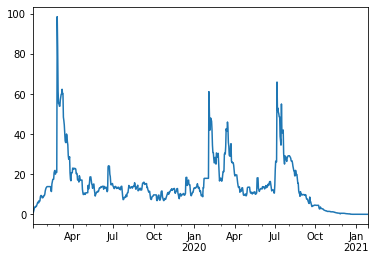

In [30]:
daily_return.add(1).cumprod().plot()